In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

# Cacher les warnings
import warnings
warnings.simplefilter("ignore")

data = pd.read_csv("data/cleaned_dataframe.csv")
data.head()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/laurent/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Tags,Merged_doc
0,['c#'],convert decimal double c# want assign decimal ...
1,"['html', 'css']",width collapse percentage width child element ...
2,"['c#', '.net']",calculate someone age base datetime type birth...
3,"['javascript', 'jquery', 'html', 'css']",jquery javascript find left inner edge element...
4,['c#'],calculate relative time c# give specific datet...


# PREPARATION

In [ ]:
import pandas as pd
import ast
from collections import Counter
import numpy as np
from typing import Union, List

def clean_and_optimize_dataset(data: pd.DataFrame):
    """
    Nettoie et optimise le dataset
    """
    print("=== NETTOYAGE ET OPTIMISATION DU DATASET ===")
    
    # ÉTAPE 1: Nettoyer les tags
    print("1. NETTOYAGE DES TAGS")
    print("-" * 30)
    
    def parse_tags_safely(tags_str: Union[str, float]) -> List[str]:
        """Parse les tags depuis string vers liste"""
        if pd.isna(tags_str):
            return []
        try:
            # Évaluer la string comme liste Python
            tags_list = ast.literal_eval(tags_str)
            return tags_list if isinstance(tags_list, list) else []
        except:
            return []
    
    # Convertir tous les tags en listes
    data['Tags_parsed'] = data['Tags'].apply(parse_tags_safely)
    
    # Supprimer les questions sans tags
    data_clean = data[data['Tags_parsed'].apply(lambda x: len(x) > 0)].copy()
    removed_count = len(data) - len(data_clean)
    
    print(f"Questions supprimées (sans tags): {removed_count}")
    print(f"Questions conservées: {len(data_clean)}")
    print(f"Pourcentage conservé: {len(data_clean)/len(data)*100:.1f}%")
    
    # ÉTAPE 2: Analyser la distribution finale
    print("\n2. DISTRIBUTION FINALE DES TAGS")
    print("-" * 35)
    
    all_tags = []
    for tags in data_clean['Tags_parsed']:
        all_tags.extend(tags)
    
    tag_distribution = Counter(all_tags)
    print(f"Total de tags: {len(all_tags)}")
    print(f"Tags uniques: {len(tag_distribution)}")
    print(f"Tags moyens par question: {len(all_tags)/len(data_clean):.2f}")
    
    # Top 15 tags
    print(f"\nTOP 15 TAGS LES PLUS FRÉQUENTS:")
    for i, (tag, count) in enumerate(tag_distribution.most_common(15), 1):
        percentage = count / len(data_clean) * 100
        print(f"{i:2d}. {tag:15s}: {count:5d} ({percentage:4.1f}%)")
    
    # ÉTAPE 3: Identifier les déséquilibres critiques
    print("\n3. ANALYSE DES DÉSÉQUILIBRES")
    print("-" * 32)
    
    tag_counts = list(tag_distribution.values())
    min_count = min(tag_counts)
    max_count = max(tag_counts)
    ratio = max_count / min_count
    
    print(f"Tag le plus rare: {min_count} exemples")
    print(f"Tag le plus fréquent: {max_count} exemples")
    print(f"Ratio de déséquilibre: {ratio:.1f}:1")
    
    if ratio > 50:
        print("🚨 DÉSÉQUILIBRE CRITIQUE détecté!")
    elif ratio > 20:
        print("⚠️  DÉSÉQUILIBRE MODÉRÉ détecté")
    else:
        print("✅ Déséquilibre acceptable")
    
    return data_clean, tag_distribution

def create_balanced_subsets(data_clean: pd.DataFrame, tag_distribution):
    """
    Crée des sous-ensembles équilibrés pour l'entraînement
    """
    print("\n=== CRÉATION DE SOUS-ENSEMBLES ÉQUILIBRÉS ===")
    
    # STRATÉGIE 1: Dataset avec tags les plus fréquents (Top 20)
    print("1. DATASET TOP 20 TAGS")
    print("-" * 25)
    
    top_20_tags = set([tag for tag, _ in tag_distribution.most_common(20)])
    
    def has_top_tags(tags_list):
        return any(tag in top_20_tags for tag in tags_list)
    
    data_top20 = data_clean[data_clean['Tags_parsed'].apply(has_top_tags)].copy()
    
    # Filtrer les tags pour ne garder que le top 20
    def filter_to_top20(tags_list):
        return [tag for tag in tags_list if tag in top_20_tags]
    
    data_top20['Tags_filtered'] = data_top20['Tags_parsed'].apply(filter_to_top20)
    data_top20 = data_top20[data_top20['Tags_filtered'].apply(lambda x: len(x) > 0)]
    
    print(f"Questions dans le top 20: {len(data_top20)}")
    print(f"Réduction: {(1 - len(data_top20)/len(data_clean))*100:.1f}%")
    
    # STRATÉGIE 2: Dataset avec tags équilibrés (min 500 exemples)
    print("\n2. DATASET TAGS ÉQUILIBRÉS")
    print("-" * 28)
    
    balanced_tags = set([tag for tag, count in tag_distribution.items() if count >= 500])
    
    def has_balanced_tags(tags_list):
        return any(tag in balanced_tags for tag in tags_list)
    
    data_balanced = data_clean[data_clean['Tags_parsed'].apply(has_balanced_tags)].copy()
    
    def filter_to_balanced(tags_list):
        return [tag for tag in tags_list if tag in balanced_tags]
    
    data_balanced['Tags_filtered'] = data_balanced['Tags_parsed'].apply(filter_to_balanced)
    data_balanced = data_balanced[data_balanced['Tags_filtered'].apply(lambda x: len(x) > 0)]
    
    print(f"Tags avec ≥500 exemples: {len(balanced_tags)}")
    print(f"Questions équilibrées: {len(data_balanced)}")
    print(f"Réduction: {(1 - len(data_balanced)/len(data_clean))*100:.1f}%")
    
    return data_top20, data_balanced

# SCRIPT PRINCIPAL
def main_optimization_pipeline(data: pd.DataFrame):
    """
    Pipeline complet d'optimisation
    """
    print("🚀 LANCEMENT DE L'OPTIMISATION COMPLÈTE")
    print("=" * 50)
    
    # 1. Nettoyage de base
    data_clean, tag_distribution = clean_and_optimize_dataset(data)
    
    # 2. Création de sous-ensembles
    data_top20, data_balanced = create_balanced_subsets(data_clean, tag_distribution)
    
    print(f"\n{'='*50}")
    print("📋 RÉSUMÉ DES DATASETS CRÉÉS:")
    print(f"{'='*50}")
    print(f"1. Dataset complet nettoyé: {len(data_clean):,} questions")
    print(f"2. Dataset Top 20 tags: {len(data_top20):,} questions")  
    print(f"3. Dataset équilibré: {len(data_balanced):,} questions")
    
    return {
        'clean': data_clean,
        'top20': data_top20, 
        'balanced': data_balanced,
        'tag_distribution': tag_distribution,
    }

# UTILISATION:
results = main_optimization_pipeline(data)

# Accéder aux datasets optimisés:
data_clean = results['clean']
data_top20 = results['top20'] 

🚀 LANCEMENT DE L'OPTIMISATION COMPLÈTE
=== NETTOYAGE ET OPTIMISATION DU DATASET ===
1. NETTOYAGE DES TAGS
------------------------------
Questions supprimées (sans tags): 16669
Questions conservées: 33331
Pourcentage conservé: 66.7%

2. DISTRIBUTION FINALE DES TAGS
-----------------------------------
Total de tags: 44552
Tags uniques: 20
Tags moyens par question: 1.34

TOP 15 TAGS LES PLUS FRÉQUENTS:
 1. javascript     :  5214 (15.6%)
 2. python         :  5197 (15.6%)
 3. java           :  4510 (13.5%)
 4. c#             :  4346 (13.0%)
 5. android        :  2829 ( 8.5%)
 6. php            :  2527 ( 7.6%)
 7. html           :  2523 ( 7.6%)
 8. c++            :  2462 ( 7.4%)
 9. ios            :  1767 ( 5.3%)
10. .net           :  1741 ( 5.2%)
11. jquery         :  1728 ( 5.2%)
12. css            :  1655 ( 5.0%)
13. sql            :  1316 ( 3.9%)
14. node.js        :  1170 ( 3.5%)
15. reactjs        :  1068 ( 3.2%)

3. ANALYSE DES DÉSÉQUILIBRES
--------------------------------
Tag le p

In [ ]:
# Problèmes identifiés et solutions

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, recall_score, precision_score
import ast
import joblib

def data_preparation(data_top20: pd.DataFrame):
    """
    Version corrigée de la préparation des données
    """
    
    print(f"\n=== PRÉPARATION CORRIGÉE DES DONNÉES ===")
    print("=" * 45)
    
    # ÉTAPE 1: NETTOYER ET PARSER LES TAGS EN PREMIER
    print("1. NETTOYAGE ET PARSING DES TAGS")
    print("-" * 35)
    
    def parse_tags(tags):
        """Parse les tags de manière robuste"""
        if pd.isna(tags):
            return []
        if isinstance(tags, str):
            try:
                return ast.literal_eval(tags)
            except:
                return []
        elif isinstance(tags, list):
            return tags
        else:
            return []
    
    # Nettoyer les données en amont
    data_prepared = data_top20.copy()
    data_prepared['Tags_parsed'] = data_prepared['Tags'].apply(parse_tags)
    
    # Supprimer les lignes sans tags
    data_prepared = data_prepared[data_prepared['Tags_parsed'].apply(lambda x: len(x) > 0)]
    
    print(f"Données après nettoyage: {len(data_prepared):,} questions")
    
    # ÉTAPE 2: BINARISATION POUR LA STRATIFICATION
    print("\n2. BINARISATION POUR STRATIFICATION")
    print("-" * 37)
    
    # Préparer X et y
    X = data_prepared['Merged_doc'].values
    y_tags = data_prepared['Tags_parsed'].values
    
    # Binariser AVANT le split pour permettre la stratification
    mlb = MultiLabelBinarizer()
    y_binary = mlb.fit_transform(y_tags)
    
    print(f"Features shape: {X.shape}")
    print(f"Labels shape: {y_binary.shape}")
    print(f"Nombre de classes: {len(mlb.classes_)}")
    print(f"Classes: {list(mlb.classes_)[:10]}...")  # Afficher les 10 premières
    
    # ÉTAPE 3: SPLIT STRATIFIÉ MULTI-LABEL
    print("\n3. SPLIT STRATIFIÉ MULTI-LABEL")
    print("-" * 32)
    
    try:
        # Essayer avec stratification multi-label
        from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
        
        splitter = MultilabelStratifiedShuffleSplit(
            n_splits=1, 
            test_size=0.2, 
            random_state=42
        )
        
        train_idx, test_idx = next(splitter.split(X, y_binary))
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train_bin, y_test_bin = y_binary[train_idx], y_binary[test_idx]
        
        print("✅ Split stratifié multi-label réussi")
        
    except ImportError:
        print("⚠️  iterstrat non disponible - split standard avec vérification")
        
        # Fallback: split standard avec vérification manuelle
        X_train, X_test, y_train_bin, y_test_bin = train_test_split(
            X, y_binary,
            test_size=0.2,
            random_state=42,
            # Utiliser une approximation de stratification
            stratify=y_binary.sum(axis=1) > 1  # Stratifier par "multi-tag" vs "single-tag"
        )
    
    print(f"Training set: {len(X_train):,} échantillons")
    print(f"Test set: {len(X_test):,} échantillons")
    
    # ÉTAPE 4: VÉRIFICATION DE LA DISTRIBUTION
    print("\n4. VÉRIFICATION DE LA DISTRIBUTION")
    print("-" * 37)
    
    train_distribution = y_train_bin.sum(axis=0)
    test_distribution = y_test_bin.sum(axis=0)
    
    print("Distribution des 10 premières classes:")
    for i in range(min(10, len(mlb.classes_))):
        class_name = mlb.classes_[i]
        train_pct = train_distribution[i] / len(X_train) * 100
        test_pct = test_distribution[i] / len(X_test) * 100
        print(f"  {class_name:12s}: train {train_pct:5.1f}% | test {test_pct:5.1f}% | ratio {train_pct/test_pct:.2f}")
    
    # Détecter les classes problématiques
    problematic_classes = []
    for i, class_name in enumerate(mlb.classes_):
        if test_distribution[i] < 5:  # Moins de 5 exemples dans le test
            problematic_classes.append((class_name, test_distribution[i]))
    
    if problematic_classes:
        print(f"\n⚠️  {len(problematic_classes)} classes avec <5 exemples dans le test:")
        for class_name, count in problematic_classes[:5]:
            print(f"     {class_name}: {count} exemples")
    
    # ÉTAPE 5: TF-IDF OPTIMISÉ
    print("\n5. VECTORISATION TF-IDF OPTIMISÉE")
    print("-" * 35)
    
    # Configuration optimisée pour votre dataset
    vocab_size = len(X_train)
    min_df_optimal = max(5, min(50, vocab_size // 1000))  # Adaptatif
    
    tfidf_vectorizer = TfidfVectorizer(
        analyzer="word",
        min_df=min_df_optimal,      # Plus flexible que 100
        max_df=0.95,                # Plus permissif que 0.8
        max_features=10000,         # Limiter la dimensionnalité
        token_pattern=r"(?u)\b\w\w+\b",  # Mots de 2+ caractères
        ngram_range=(1, 2),         # Inclure bigrammes
        stop_words='english',       # Supprimer stop words
        sublinear_tf=True          # Améliore les performances
    )
    
    print(f"Configuration TF-IDF:")
    print(f"  - min_df: {min_df_optimal}")
    print(f"  - max_df: 0.95")
    print(f"  - max_features: 10,000")
    print(f"  - ngrams: (1,2)")
    
    # Fit et transform
    X_tfidf_train = tfidf_vectorizer.fit_transform(X_train)
    X_tfidf_test = tfidf_vectorizer.transform(X_test)
    
    print(f"\nRésultat TF-IDF:")
    print(f"  Training: {X_tfidf_train.shape}")
    print(f"  Test: {X_tfidf_test.shape}")
    print(f"  Vocabulaire: {len(tfidf_vectorizer.get_feature_names_out())} mots")
    
    # ÉTAPE 6: MÉTRIQUES
    print("\n6. FONCTION DE MÉTRIQUES")
    print("-" * 37)
    
    def metric_score(model_name, y_true, y_pred, metrics_df=None):
        """
        Fonction de métriques corrigée pour multi-label
        """
        
        # Métriques appropriées pour multi-label
        results = {
            'F1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
            'F1_micro': f1_score(y_true, y_pred, average='micro', zero_division=0),
            'F1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'Precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
            'Recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
            'Jaccard_macro': jaccard_score(y_true, y_pred, average='macro', zero_division=0),
            'Subset_accuracy': accuracy_score(y_true, y_pred),  # Exact match
        }
        
        # Calculer Hamming Loss (spécifique multi-label)
        from sklearn.metrics import hamming_loss
        results['Hamming_loss'] = hamming_loss(y_true, y_pred)
        
        new_col = pd.DataFrame(results, index=[model_name]).T
        
        if metrics_df is None:
            metrics_df = new_col
        else:
            metrics_df[model_name] = new_col[model_name]
        
        return metrics_df
    
    print("✅ Métriques multi-label configurées:")
    print("   - F1 macro/micro/weighted")
    print("   - Precision/Recall macro") 
    print("   - Jaccard macro")
    print("   - Subset accuracy (exact match)")
    print("   - Hamming loss")
    
    # ÉTAPE 7: SAUVEGARDE SÉCURISÉE
    print("\n7. SAUVEGARDE DES OBJETS")
    print("-" * 25)
    
    # Sauvegarder avec métadonnées
    objects_to_save = {
        'tfidf_vectorizer': tfidf_vectorizer,
        'mlb': mlb,
        'feature_names': tfidf_vectorizer.get_feature_names_out(),
        'classes': mlb.classes_,
        'train_size': len(X_train),
        'test_size': len(X_test),
        'vocab_size': X_tfidf_train.shape[1]
    }
    
    for name, obj in objects_to_save.items():
        if name in ['feature_names', 'classes', 'train_size', 'test_size', 'vocab_size']:
            continue  # Skip metadata
        joblib.dump(obj, f'{name}_final.pkl')
        print(f"✅ {name} sauvegardé")
    
    return {
        'X_train': X_train,
        'X_test': X_test, 
        'X_tfidf_train': X_tfidf_train,
        'X_tfidf_test': X_tfidf_test,
        'y_train_bin': y_train_bin,
        'y_test_bin': y_test_bin,
        'mlb': mlb,
        'tfidf_vectorizer': tfidf_vectorizer,
        'metric_function': metric_score
    }

In [ ]:
# 1. Préparer les données
prepared_data = data_preparation(data_top20)

# 2. Récupérer les objets
X_train = prepared_data['X_train']
X_test = prepared_data['X_test']
X_tfidf_train = prepared_data['X_tfidf_train']
X_tfidf_test = prepared_data['X_tfidf_test'] 
Y_train_bin = prepared_data['y_train_bin']
Y_test_bin = prepared_data['y_test_bin']
mlb = prepared_data['mlb']
metric_func = prepared_data['metric_function']



=== PRÉPARATION CORRIGÉE DES DONNÉES ===
1. NETTOYAGE ET PARSING DES TAGS
-----------------------------------
Données après nettoyage: 33,331 questions

2. BINARISATION POUR STRATIFICATION
-------------------------------------
Features shape: (33331,)
Labels shape: (33331, 20)
Nombre de classes: 20
Classes: ['.net', 'android', 'arrays', 'asp.net', 'c#', 'c++', 'css', 'html', 'ios', 'java']...

3. SPLIT STRATIFIÉ MULTI-LABEL
--------------------------------
⚠️  iterstrat non disponible - split standard avec vérification
Training set: 26,664 échantillons
Test set: 6,667 échantillons

4. VÉRIFICATION DE LA DISTRIBUTION
-------------------------------------
Distribution des 10 premières classes:
  .net        : train   5.3% | test   5.1% | ratio 1.04
  android     : train   8.2% | test   9.4% | ratio 0.87
  arrays      : train   2.8% | test   2.7% | ratio 1.06
  asp.net     : train   3.0% | test   2.9% | ratio 1.04
  c#          : train  13.0% | test  13.1% | ratio 0.99
  c++         : tr

# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.metrics import make_scorer

mlflow.end_run()

param_rfc = {
    "estimator__max_depth": [5, 25, 50],
    "estimator__min_samples_leaf": [1, 5, 10],
    "estimator__n_estimators": [50, 100],
    "estimator__class_weight": ["balanced"]
}

mlflow.set_experiment("Multilabel_TFIDF_RF_2")
f1_micro_scorer = make_scorer(f1_score, average='micro')

from sklearn.metrics import make_scorer

with mlflow.start_run(run_name="GridSearch_RF", nested=True):

    multi_rfc_cv = GridSearchCV(
        OneVsRestClassifier(RandomForestClassifier()),
        param_grid=param_rfc,
        n_jobs=4,
        cv=2,
        scoring=f1_micro_scorer,
        return_train_score=True,
        refit=True,
        verbose=3
    )

    multi_rfc_cv.fit(X_tfidf_train, Y_train_bin)

    # Log des meilleurs hyperparamètres
    mlflow.log_params(multi_rfc_cv.best_params_)

    # Résultats de validation croisée
    rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
    rfc_cv_results.to_csv("rfc_cv_results.csv", index=False)
    mlflow.log_artifact("rfc_cv_results.csv")

    print("-"*50)
    print("Best params for RandomForestClassifier")
    print("-"*50)
    print(multi_rfc_cv.best_params_)

    y_test_predicted_labels_tfidf_rfc = multi_rfc_cv.predict(X_tfidf_test)

    print(f"Shape des prédictions: {y_test_predicted_labels_tfidf_rfc.shape}")
    print(f"Nombre de 1 dans les prédictions: {y_test_predicted_labels_tfidf_rfc.sum()}")
    print(f"Pourcentage de 1: {y_test_predicted_labels_tfidf_rfc.mean()*100:.2f}%")

    # Métriques
    metrics_df = metric_func("RF", Y_test_bin, y_test_predicted_labels_tfidf_rfc)
    mlflow.log_metric("accuracy", metrics_df.loc["Subset_accuracy", "RF"])
    mlflow.log_metric("f1_score_macro", metrics_df.loc["F1_macro", "RF"])
    mlflow.log_metric("f1_score_micro", metrics_df.loc["F1_micro", "RF"])
    mlflow.log_metric("f1_score_weighted", metrics_df.loc["F1_weighted", "RF"])
    mlflow.log_metric("jaccard", metrics_df.loc["Jaccard_macro", "RF"])
    mlflow.log_metric("recall", metrics_df.loc["Recall_macro", "RF"])
    mlflow.log_metric("precision", metrics_df.loc["Precision_macro", "RF"])

    # Log du modèle
    mlflow.sklearn.log_model(multi_rfc_cv.best_estimator_, name="model")

    # Affichage des 10 premières prédictions
    y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf_rfc)
    y_test_inversed = mlb.inverse_transform(Y_test_bin)

    print("-"*50)
    print("Print 10 first predicted Tags vs true Tags")
    print("-"*50)
    print("Predicted:", y_test_pred_inversed[:10])
    print("True:", y_test_inversed[:10])

mlflow.end_run()


Fitting 2 folds for each of 18 candidates, totalling 36 fits
--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 50, 'estimator__min_samples_leaf': 5, 'estimator__n_estimators': 100}


2025/08/04 17:12:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Shape des prédictions: (6667, 20)
Nombre de 1 dans les prédictions: 10136
Pourcentage de 1: 7.60%


2025/08/04 17:12:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--------------------------------------------------
Print 10 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('c#',), ('arrays', 'javascript'), ('c#', 'sql', 'sql-server'), (), ('android', 'java'), ('arrays', 'python'), ('html', 'javascript', 'jquery'), ('python',), ('c#',), ('javascript', 'reactjs')]
True: [('c#',), ('arrays', 'javascript'), ('c#', 'sql-server'), ('php',), ('java',), ('python',), ('javascript', 'jquery'), ('python',), ('c#',), ('javascript', 'reactjs')]


In [34]:
metrics_df

,RF
F1_macro,0.717541
F1_micro,0.743528
F1_weighted,0.751403
Precision_macro,0.685453
Recall_macro,0.763355
Jaccard_macro,0.571757
Subset_accuracy,0.496625
Hamming_loss,0.036703


# LOGISTIC REGRESSION

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import ast
import pandas as pd
import mlflow
import mlflow.sklearn

mlflow.end_run()

# Paramètres pour la recherche
param_logit = {
    "estimator__C": [100, 10, 1.0, 0.1],
    "estimator__penalty": ["l1", "l2"],
    "estimator__solver": ["liblinear"],  # Bon compromis vitesse/convergence
    "estimator__class_weight": ["balanced"],
    "estimator__tol": [1e-4]  # Critère de convergence moins strict
}

# Début du run MLflow
mlflow.set_experiment("Multilabel_TFIDF_LogReg_2")

with mlflow.start_run(run_name="GridSearch_LogReg", nested=True):

    # GridSearch
    multi_logit_cv = GridSearchCV(
        OneVsRestClassifier(LogisticRegression()),
        param_grid=param_logit,
        n_jobs=-1,
        cv=5,
        scoring="f1_weighted",
        return_train_score=True,
        refit=True,
        verbose=3
    )
    multi_logit_cv.fit(X_tfidf_train, Y_train_bin)

    # Log des hyperparamètres optimaux
    mlflow.log_params(multi_logit_cv.best_params_)

    # Prédictions
    y_test_predicted_labels_tfidf = multi_logit_cv.predict(X_tfidf_test)

    # Évaluation
    print(f"Shape des prédictions: {y_test_predicted_labels_tfidf.shape}")
    print(f"Nombre de 1 dans les prédictions: {y_test_predicted_labels_tfidf.sum()}")
    print(f"Pourcentage de 1: {y_test_predicted_labels_tfidf.mean()*100:.2f}%")

    # Métriques
    metrics_df = metric_func("Log_Reg", Y_test_bin, y_test_predicted_labels_tfidf, metrics_df)
    mlflow.log_metric("accuracy", metrics_df.loc["Subset_accuracy", "Log_Reg"])
    mlflow.log_metric("f1_score_macro", metrics_df.loc["F1_macro", "Log_Reg"])
    mlflow.log_metric("f1_score_micro", metrics_df.loc["F1_micro", "Log_Reg"])
    mlflow.log_metric("f1_score_weighted", metrics_df.loc["F1_weighted", "Log_Reg"])
    mlflow.log_metric("jaccard", metrics_df.loc["Jaccard_macro", "Log_Reg"])
    mlflow.log_metric("recall", metrics_df.loc["Recall_macro", "Log_Reg"])
    mlflow.log_metric("precision", metrics_df.loc["Precision_macro", "Log_Reg"])

    # Log du modèle
    mlflow.sklearn.log_model(multi_logit_cv.best_estimator_, name="model")

    # Optionnel : log d'artefacts comme CSV
    logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
    logit_cv_results.to_csv("logit_cv_results.csv", index=False)
    mlflow.log_artifact("logit_cv_results.csv")

    # Print comparaison prédictions
    y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
    y_test_inversed = mlb.inverse_transform(Y_test_bin)
    print("Predicted:", y_test_pred_inversed[:10])
    print("True:", y_test_inversed[:10])

mlflow.end_run()


[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=1, estimator__n_estimators=50;, score=(train=0.647, test=0.611) total time=   4.7s
[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=5, estimator__n_estimators=50;, score=(train=0.618, test=0.597) total time=   4.5s
[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__n_estimators=50;, score=(train=0.612, test=0.594) total time=   4.4s
[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=10, estimator__n_estimators=100;, score=(train=0.639, test=0.618) total time=   8.3s
[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=1, estimator__n_estimators=100;, score=(train=0.930, test=0.711) total time=  30.4s
[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__mi

2025/08/04 17:14:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Shape des prédictions: (6667, 20)
Nombre de 1 dans les prédictions: 10460
Pourcentage de 1: 7.84%


2025/08/04 17:14:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Predicted: [('.net', 'c#'), ('arrays', 'javascript'), ('c#', 'sql-server'), (), ('android',), ('python',), ('html', 'javascript', 'jquery'), ('python',), ('.net', 'c#'), ('javascript', 'reactjs')]
True: [('c#',), ('arrays', 'javascript'), ('c#', 'sql-server'), ('php',), ('java',), ('python',), ('javascript', 'jquery'), ('python',), ('c#',), ('javascript', 'reactjs')]


In [36]:
metrics_df

,RF,Log_Reg
F1_macro,0.717541,0.731599
F1_micro,0.743528,0.755849
F1_weighted,0.751403,0.763459
Precision_macro,0.685453,0.678765
Recall_macro,0.763355,0.801186
Jaccard_macro,0.571757,0.589822
Subset_accuracy,0.496625,0.516724
Hamming_loss,0.036703,0.035533


# SVM

In [ ]:
from sklearn.svm import LinearSVC

# Fermer toute session MLflow active
mlflow.end_run()

# Paramètres pour GridSearch SVM
param_svc = {
    "estimator__C": [0.1, 1, 10],  # Paramètre de régularisation
    "estimator__loss": ['hinge', 'squared_hinge'],  # Type de loss
    "estimator__class_weight": ['balanced'],  # Pour gérer le déséquilibre
    "estimator__max_iter": [2000]  # Nombre max d'itérations
}

# Configuration MLflow
mlflow.set_experiment("Multilabel_TFIDF_SVM_2")

with mlflow.start_run(run_name="GridSearch_SVM", nested=True):
    
    print("Début de l'entraînement SVM...")
    
    # Création du modèle SVM multi-label
    multi_svc_cv = GridSearchCV(
        OneVsRestClassifier(LinearSVC(random_state=42, dual=False)),
        param_grid=param_svc,
        n_jobs=4,
        cv=3,  # 3-fold cross validation
        scoring="f1_weighted",  # Métrique optimisée
        return_train_score=True,
        refit=True,
        verbose=2
    )
    
    # Entraînement (utilisez vos données TF-IDF sans PCA pour de meilleurs résultats)
    print("Entraînement en cours...")
    multi_svc_cv.fit(X_tfidf_train, Y_train_bin)  # Utilisation directe de TF-IDF sparse
    
    # Log des meilleurs hyperparamètres
    mlflow.log_params(multi_svc_cv.best_params_)
    
    # Sauvegarde des résultats de validation croisée
    svc_cv_results = pd.DataFrame.from_dict(multi_svc_cv.cv_results_)
    svc_cv_results.to_csv("svc_cv_results.csv", index=False)
    mlflow.log_artifact("svc_cv_results.csv")
    
    print("-" * 50)
    print("Meilleurs paramètres pour LinearSVC:")
    print("-" * 50)
    print(multi_svc_cv.best_params_)
    print(f"Meilleur score CV: {multi_svc_cv.best_score_:.4f}")
    
    # Prédictions sur le jeu de test
    print("Prédictions en cours...")
    y_test_predicted_labels_tfidf_svc = multi_svc_cv.predict(X_tfidf_test)
    
    print(f"Shape des prédictions: {y_test_predicted_labels_tfidf_svc.shape}")
    print(f"Nombre de 1 dans les prédictions: {y_test_predicted_labels_tfidf_svc.sum()}")
    print(f"Pourcentage de 1: {y_test_predicted_labels_tfidf_svc.mean()*100:.2f}%")
    
    
    metrics_df_svm = metric_func("SVM", Y_test_bin, y_test_predicted_labels_tfidf_svc, metrics_df=metrics_df)
    mlflow.log_metric("accuracy", metrics_df.loc["Subset_accuracy", "SVM"])
    mlflow.log_metric("f1_score_macro", metrics_df.loc["F1_macro", "SVM"])
    mlflow.log_metric("f1_score_micro", metrics_df.loc["F1_micro", "SVM"])
    mlflow.log_metric("f1_score_weighted", metrics_df.loc["F1_weighted", "SVM"])
    mlflow.log_metric("jaccard", metrics_df.loc["Jaccard_macro", "SVM"])
    mlflow.log_metric("recall", metrics_df.loc["Recall_macro", "SVM"])
    mlflow.log_metric("precision", metrics_df.loc["Precision_macro", "SVM"])
    
    # Log du modèle
    mlflow.sklearn.log_model(multi_logit_cv.best_estimator_, name="model")
    
    # Affichage des résultats
    print("-" * 50)
    print("RÉSULTATS SVM:")
    print("-" * 50)
    print(metrics_df_svm)
    
    # Comparaison des prédictions avec la vérité terrain
    y_test_pred_inversed_svm = mlb.inverse_transform(y_test_predicted_labels_tfidf_svc)
    y_test_inversed = mlb.inverse_transform(Y_test_bin)
    
    print("-" * 50)
    print("10 premiers exemples - Tags prédits vs vrais tags:")
    print("-" * 50)
    for i in range(10):
        print(f"Exemple {i+1}:")
        print(f"  Prédits: {y_test_pred_inversed_svm[i]}")
        print(f"  Vrais:   {y_test_inversed[i]}")
        print()

print("Entraînement SVM terminé!")

Début de l'entraînement SVM...
Entraînement en cours...
[CV 3/5] END estimator__C=100, estimator__class_weight=balanced, estimator__penalty=l2, estimator__solver=liblinear, estimator__tol=0.0001;, score=(train=0.994, test=0.747) total time=  11.0s
[CV 4/5] END estimator__C=100, estimator__class_weight=balanced, estimator__penalty=l2, estimator__solver=liblinear, estimator__tol=0.0001;, score=(train=0.994, test=0.747) total time=  10.6s
[CV 2/5] END estimator__C=10, estimator__class_weight=balanced, estimator__penalty=l1, estimator__solver=liblinear, estimator__tol=0.0001;, score=(train=0.967, test=0.737) total time=  26.1s
[CV 5/5] END estimator__C=1.0, estimator__class_weight=balanced, estimator__penalty=l1, estimator__solver=liblinear, estimator__tol=0.0001;, score=(train=0.805, test=0.739) total time=   9.0s
[CV 4/5] END estimator__C=1.0, estimator__class_weight=balanced, estimator__penalty=l2, estimator__solver=liblinear, estimator__tol=0.0001;, score=(train=0.831, test=0.751) tota

2025/08/04 17:14:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


--------------------------------------------------
Meilleurs paramètres pour LinearSVC:
--------------------------------------------------
{'estimator__C': 1, 'estimator__class_weight': 'balanced', 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 2000}
Meilleur score CV: 0.7554
Prédictions en cours...
Shape des prédictions: (6667, 20)
Nombre de 1 dans les prédictions: 10220
Pourcentage de 1: 7.66%


2025/08/04 17:14:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


--------------------------------------------------
RÉSULTATS SVM:
--------------------------------------------------
                       RF   Log_Reg       SVM
F1_macro         0.717541  0.731599  0.727264
F1_micro         0.743528  0.755849  0.750913
F1_weighted      0.751403  0.763459  0.757796
Precision_macro  0.685453  0.678765  0.689929
Recall_macro     0.763355  0.801186  0.774880
Jaccard_macro    0.571757  0.589822  0.584139
Subset_accuracy  0.496625  0.516724  0.517324
Hamming_loss     0.036703  0.035533  0.035803
--------------------------------------------------
10 premiers exemples - Tags prédits vs vrais tags:
--------------------------------------------------
Exemple 1:
  Prédits: ('.net', 'c#')
  Vrais:   ('c#',)

Exemple 2:
  Prédits: ('arrays', 'javascript')
  Vrais:   ('arrays', 'javascript')

Exemple 3:
  Prédits: ('c#', 'sql-server')
  Vrais:   ('c#', 'sql-server')

Exemple 4:
  Prédits: ('node.js',)
  Vrais:   ('php',)

Exemple 5:
  Prédits: ('android',)
  Vrais:

In [38]:
metrics_df

,RF,Log_Reg,SVM
F1_macro,0.717541,0.731599,0.727264
F1_micro,0.743528,0.755849,0.750913
F1_weighted,0.751403,0.763459,0.757796
Precision_macro,0.685453,0.678765,0.689929
Recall_macro,0.763355,0.801186,0.774880
Jaccard_macro,0.571757,0.589822,0.584139
Subset_accuracy,0.496625,0.516724,0.517324
Hamming_loss,0.036703,0.035533,0.035803


# LDA

# WORD2VEC

In [ ]:
import mlflow
import mlflow.sklearn
import numpy as np
import tempfile
import os
import json
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Tokenisation
X_train_tok = [word_tokenize(doc) for doc in X_train if pd.notna(doc)]
X_test_tok = [word_tokenize(doc) for doc in X_test if pd.notna(doc)]

# === Début du run MLflow ===
mlflow.set_experiment("Word2Vec_Classifier")

with mlflow.start_run(run_name="W2V + LogisticRegression", nested=True):

    # Hyperparams
    vector_size = 100
    window = 5
    min_count = 2
    sg = 1  # skip-gram

    # Log des params
    mlflow.log_params({
        "vector_size": vector_size,
        "window": window,
        "min_count": min_count,
        "sg": sg,
        "classifier": "LogisticRegression"
    })

    # Entraînement Word2Vec
    model_w2v = Word2Vec(sentences=X_train_tok, vector_size=vector_size,
                         window=window, min_count=min_count, workers=4, sg=sg)

    # Sauvegarde du modèle Word2Vec
    with tempfile.TemporaryDirectory() as tmpdir:
        w2v_path = os.path.join(tmpdir, "word2vec.model")
        model_w2v.save(w2v_path)
        mlflow.log_artifact(w2v_path, artifact_path="w2v_model")

    # Vectorisation
    def vectorize_doc(doc_tokens, model):
        vectors = [model.wv[word] for word in doc_tokens if word in model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

    X_train_vec = np.array([vectorize_doc(doc, model_w2v) for doc in X_train_tok])
    X_test_vec = np.array([vectorize_doc(doc, model_w2v) for doc in X_test_tok])

    # Classification
    clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    clf.fit(X_train_vec, Y_train_bin)

    Y_pred_bin = clf.predict(X_test_vec)

    # Logging modèle Sklearn
    mlflow.sklearn.log_model(clf, name="model")

    # Métriques
    metrics_df = metric_func("Word2Vec", Y_test_bin, Y_pred_bin, metrics_df)

    mlflow.log_metric("accuracy", metrics_df.loc["Subset_accuracy", "Word2Vec"])
    mlflow.log_metric("f1_score_macro", metrics_df.loc["F1_macro", "Word2Vec"])
    mlflow.log_metric("f1_score_micro", metrics_df.loc["F1_micro", "Word2Vec"])
    mlflow.log_metric("f1_score_weighted", metrics_df.loc["F1_weighted", "Word2Vec"])
    mlflow.log_metric("jaccard", metrics_df.loc["Jaccard_macro", "Word2Vec"])
    mlflow.log_metric("recall", metrics_df.loc["Recall_macro", "Word2Vec"])
    mlflow.log_metric("precision", metrics_df.loc["Precision_macro", "Word2Vec"])

mlflow.end_run()


2025/08/04 17:15:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/04 17:15:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [40]:
metrics_df

,RF,Log_Reg,SVM,Word2Vec
F1_macro,0.717541,0.731599,0.727264,0.561472
F1_micro,0.743528,0.755849,0.750913,0.642920
F1_weighted,0.751403,0.763459,0.757796,0.629765
Precision_macro,0.685453,0.678765,0.689929,0.772534
Recall_macro,0.763355,0.801186,0.774880,0.456399
Jaccard_macro,0.571757,0.589822,0.584139,0.410888
Subset_accuracy,0.496625,0.516724,0.517324,0.430028
Hamming_loss,0.036703,0.035533,0.035803,0.039696


# BERT

In [41]:
import os
import tensorflow_hub as hub
import tensorflow as tf
import transformers
from transformers import AutoTokenizer, AutoConfig, TFAutoModel
import time
from sklearn.decomposition import PCA

In [42]:
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids, token_type_ids, attention_mask = [], [], []
    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True,
            return_tensors="tf"
        )
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])

    return (
        np.asarray(input_ids),
        np.asarray(token_type_ids),
        np.asarray(attention_mask)
    )

def feature_BERT_fct(model, tokenizer, sentences, max_length, batch_size):
    all_embeddings = []
    num_batches = (len(sentences) + batch_size - 1) // batch_size
    for i in range(num_batches):
        batch_sentences = sentences[i * batch_size : (i + 1) * batch_size]
        input_ids, token_type_ids, attention_mask = bert_inp_fct(batch_sentences, tokenizer, max_length)

        outputs = model([input_ids, attention_mask, token_type_ids], training=False)
        last_hidden_state = outputs.last_hidden_state.numpy()  # (batch_size, seq_len, hidden_dim)

        # Moyenne sur la séquence
        mean_embeddings = np.mean(last_hidden_state, axis=1)
        all_embeddings.append(mean_embeddings)

    return np.vstack(all_embeddings)

# === Modèle BERT HF ===
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)

max_length = 32
batch_size = 10

# === Extraction des features BERT ===
X_train_bert = feature_BERT_fct(bert_model, tokenizer, X_train, max_length, batch_size)
X_test_bert = feature_BERT_fct(bert_model, tokenizer, X_test, max_length, batch_size)

# === Réduction de dimension ===
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_bert)
X_test_pca = pca.transform(X_test_bert)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

[CV] END estimator__C=0.1, estimator__class_weight=balanced, estimator__loss=hinge, estimator__max_iter=2000; total time=   0.0s
[CV] END estimator__C=0.1, estimator__class_weight=balanced, estimator__loss=squared_hinge, estimator__max_iter=2000; total time=   2.4s
[CV] END estimator__C=1, estimator__class_weight=balanced, estimator__loss=squared_hinge, estimator__max_iter=2000; total time=   3.9s
[CV] END estimator__C=0.1, estimator__class_weight=balanced, estimator__loss=hinge, estimator__max_iter=2000; total time=   0.0s
[CV] END estimator__C=0.1, estimator__class_weight=balanced, estimator__loss=squared_hinge, estimator__max_iter=2000; total time=   2.4s
[CV] END estimator__C=10, estimator__class_weight=balanced, estimator__loss=hinge, estimator__max_iter=2000; total time=   0.0s
[CV] END estimator__C=10, estimator__class_weight=balanced, estimator__loss=hinge, estimator__max_iter=2000; total time=   0.0s
[CV] END estimator__C=10, estimator__class_weight=balanced, estimator__loss=h

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

mlflow.set_experiment("Multilabel_BERT")

with mlflow.start_run(run_name="LogReg_BERT", nested=True):
    clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    clf.fit(X_train_pca, Y_train_bin)

    # === Prédictions ===
    y_pred = clf.predict(X_test_pca)
    # Metrics
    metrics_df = metric_func("Bert", Y_test_bin, Y_pred_bin, metrics_df)

    model_type = 'bert-base-uncased'
    # Log params
    mlflow.log_param("BERT_model", model_type)
    mlflow.log_param("max_length", max_length)
    mlflow.log_param("pca_components", 100)

    # Log metrics (juste après calcul)
    mlflow.log_metric("accuracy", metrics_df.loc["Subset_accuracy", "Bert"])
    mlflow.log_metric("f1_score_macro", metrics_df.loc["F1_macro", "Bert"])
    mlflow.log_metric("f1_score_micro", metrics_df.loc["F1_micro", "Bert"])
    mlflow.log_metric("f1_score_weighted", metrics_df.loc["F1_weighted", "Bert"])
    mlflow.log_metric("jaccard", metrics_df.loc["Jaccard_macro", "Bert"])
    mlflow.log_metric("recall", metrics_df.loc["Recall_macro", "Bert"])
    mlflow.log_metric("precision", metrics_df.loc["Precision_macro", "Bert"])

    # Log model
    mlflow.sklearn.log_model(clf, name="model")

mlflow.end_run()

# Affichage final
metrics_df


2025/08/04 17:33:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025/08/04 17:33:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


,RF,Log_Reg,SVM,Word2Vec,Bert
F1_macro,0.717541,0.731599,0.727264,0.561472,0.561472
F1_micro,0.743528,0.755849,0.750913,0.642920,0.642920
F1_weighted,0.751403,0.763459,0.757796,0.629765,0.629765
Precision_macro,0.685453,0.678765,0.689929,0.772534,0.772534
Recall_macro,0.763355,0.801186,0.774880,0.456399,0.456399
Jaccard_macro,0.571757,0.589822,0.584139,0.410888,0.410888
Subset_accuracy,0.496625,0.516724,0.517324,0.430028,0.430028
Hamming_loss,0.036703,0.035533,0.035803,0.039696,0.039696


# USE

In [44]:
import os
import time
import numpy as np
import joblib

import tensorflow as tf
import tensorflow_hub as hub
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Définir le cache temporaire
os.environ["TFHUB_CACHE_DIR"] = "/tmp/tfhub_cache"

# Charger le modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [45]:
def feature_USE_fct(sentences, batch_size):
    features = []
    time1 = time.time()

    for step in range(0, len(sentences), batch_size):
        batch = sentences[step:step + batch_size]

        # 🔽 Correction ici : aplatir si array 2D
        if isinstance(batch, np.ndarray):
            batch = batch.ravel().tolist()

        feat = embed(batch)
        features.append(feat.numpy())

    features = np.vstack(features)
    print(f"Temps d'encodage : {np.round(time.time() - time1, 2)} sec")

    return features

X_train = np.ravel(X_train).tolist()
X_test = np.ravel(X_test).tolist()

In [46]:
from sklearn.preprocessing import StandardScaler

def display_scree_plot(pca):
  fig=plt.figure(figsize=(8,8))
  scree = pca.explained_variance_ratio_*100
  plt.bar(np.arange(len(scree))+1, scree)
  plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
  plt.xlabel("rang de l'axe d'inertie")
  plt.ylabel("pourcentage d'inertie")
  plt.title("Eboulis des valeurs propres")
  plt.show()

def pca_transformation(train , test):
    scaler = StandardScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)
    n_comp = train.shape[1]
    pca = PCA(n_components=n_comp)
    pca.fit(train)
    display_scree_plot(pca)
    pca = PCA(n_components=0.8, random_state=42)
    pca.fit(train)
    train_pca = pca.transform(train)
    test_pca = pca.transform(test)
    print("\nNous conservons {} composantes principales pour garder 80% d'inertie".format(pca.components_.shape[0]))
    return train_pca, test_pca, pca

batch_size = 10

Temps d'encodage : 9.99 sec
Temps d'encodage : 2.42 sec


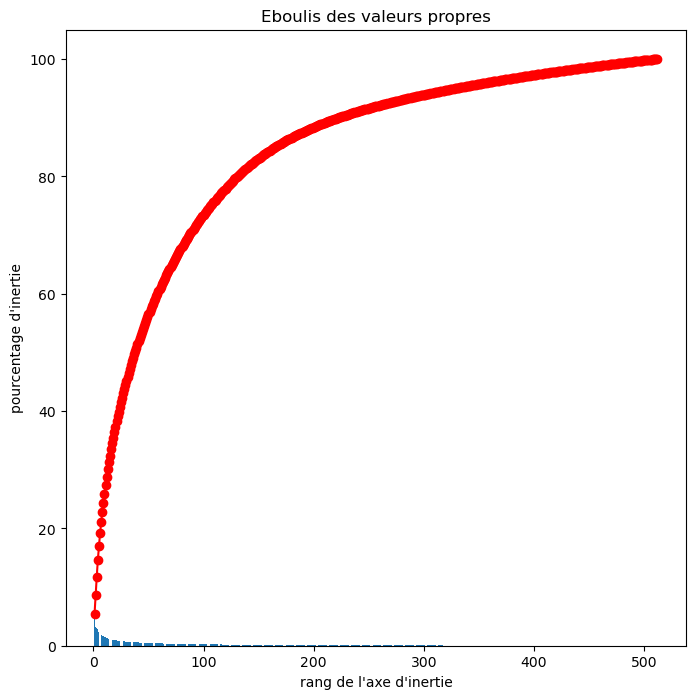


Nous conservons 131 composantes principales pour garder 80% d'inertie


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,RF,Log_Reg,SVM,Word2Vec,Bert,USE
F1_macro,0.717541,0.731599,0.727264,0.561472,0.561472,0.672210
F1_micro,0.743528,0.755849,0.750913,0.642920,0.642920,0.725258
F1_weighted,0.751403,0.763459,0.757796,0.629765,0.629765,0.717887
Precision_macro,0.685453,0.678765,0.689929,0.772534,0.772534,0.777378
Recall_macro,0.763355,0.801186,0.774880,0.456399,0.456399,0.598919
Jaccard_macro,0.571757,0.589822,0.584139,0.410888,0.410888,0.522264
Subset_accuracy,0.496625,0.516724,0.517324,0.430028,0.430028,0.524224
Hamming_loss,0.036703,0.035533,0.035803,0.039696,0.039696,0.033291


In [47]:
mlflow.set_experiment("Multilabel_USE")

with mlflow.start_run(run_name="LogReg_USE", nested=True):
    # Encodage avec USE
    X_use_train = feature_USE_fct(X_train, batch_size)
    X_use_test = feature_USE_fct(X_test, batch_size)

    # PCA
    X_train_use_pca, X_test_use_pca, pca_use = pca_transformation(X_use_train, X_use_test)
    n_components = pca_use.n_components_

    # Log des paramètres
    mlflow.log_param("embedding", "USE")
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("pca_components", n_components)
    mlflow.log_param("C", 10)
    mlflow.log_param("penalty", "l1")
    mlflow.log_param("solver", "liblinear")

    # Modèle
    logit_use_pca = OneVsRestClassifier(
        LogisticRegression(C=10, penalty="l1", dual=False, solver="liblinear"),
        n_jobs=-1
    )
    logit_use_pca.fit(X_train_use_pca, Y_train_bin)

    # Prédictions
    Y_pred_use = logit_use_pca.predict(X_test_use_pca)

    metrics_df = metric_func("USE", Y_test_bin, Y_pred_use, metrics_df)

    # Log métriques
    mlflow.log_metric("accuracy", metrics_df.loc["Subset_accuracy", "USE"])
    mlflow.log_metric("f1_score_macro", metrics_df.loc["F1_macro", "USE"])
    mlflow.log_metric("f1_score_micro", metrics_df.loc["F1_micro", "USE"])
    mlflow.log_metric("f1_score_weighted", metrics_df.loc["F1_weighted", "USE"])
    mlflow.log_metric("jaccard", metrics_df.loc["Jaccard_macro", "USE"])
    mlflow.log_metric("recall", metrics_df.loc["Recall_macro", "USE"])
    mlflow.log_metric("precision", metrics_df.loc["Precision_macro", "USE"])

    # Log du modèle
    mlflow.sklearn.log_model(logit_use_pca, "model")

mlflow.end_run()

metrics_df